# NOTES

Big sections:
* data ingestion and examination
  * only 50 rows have labels for has_cancer and has_diabetes
    * 20 positives for has_cancer, only 5 positives for has_diabetes
  * use these 50 rows to do some validation and checks
    * where do diabetes key words show up in has_diabetes==1
    * examples of diabetes key words showing up in has_diabetes==0
    * repeat for has_cancer
  * how do we validate 
* breaking up text data to different sections, and getting ready for modeling
  * fields of relevance, fields to ignore, fields to sometimes consider
* looking for diabetes
  * should only be for patients currently diabetic
    * probably don't want to try and separate out cases where diabetes is in treatment
    * it may be good to separately tag when diabetes is in patient's family history, or past history
  * search things like 'glucose' will be way too broad, as it comes up in normal bloodwork. will need more context around those terms
  * check in spaCy?
* looking for cancer
  * remember, here we're looking for whether patient had cancer at any time
  * much bigger set of words to look for
  * 

# CODE

## Preamble

In [78]:
import pandas as pd
import re
import spacy
# from scispacy import en_core_sci_lg
from scispacy.umls_linking import UmlsEntityLinker
from spacy.language import Language
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
# read in data
rawdat = pd.read_csv('data/layer-data-sci-takehome-05062024.csv')

# separate out test set
traindat = rawdat.loc[rawdat['test_set']==0]
testdat = rawdat.loc[rawdat['test_set']==1]

# separate out labeled data
labeldat = traindat.loc[traindat['has_cancer'].notnull()]
nolabeldat = traindat.loc[traindat['has_cancer'].isnull()]

print(traindat.shape)
print(testdat.shape)
print(labeldat.shape)
print(nolabeldat.shape)

(1800, 5)
(200, 5)
(50, 5)
(1750, 5)


# Basic functions

In [4]:
def remove_namefields(text):
    # Replace patterns that might represent PII placeholders like "[Name]", "[Redacted]", etc.
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'Patient Name:.*\n', '', text, flags=re.IGNORECASE)
    return text

def normalize_text(text):
    '''
    Normalize text data by lowercasing, removing punctuation, and extra whitespace
    '''
    text = text.lower() 
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'\d+', '', text) 
    text = re.sub(r'\s+', ' ', text).strip() 
    return text


# EDA

## Text examination

First thing noticed is that there's lots of different header sections in the data

Headers start with a newline (or start of the field) and end with a colon

In [5]:
### Header extraction and analysis
# pattern for extracting headers:
    # 1. First character is a capital letter
    # 2. followed by any combination of letters, spaces, commas, hyphens
    # 3. ends with a colon and optional whitespace
header_pattern = r'(?m)(?:^|(?<=\n))[A-Z][a-zA-Z\s,-]+:\s*$'

def find_header(textfield, pattern=header_pattern):
    '''
    Extracts headers from a single text field, given a header pattern
    Returns list of headers found'''
    return re.findall(pattern, textfield)

def count_headers(df, pattern=header_pattern):
    '''
    Extracts headers from all text fields in a dataframe df
    Returns a dictionary of headers and their counts'''
    header_counts = {}

    for text in df['text']:
        headers = find_header(text, pattern)
        for header in headers:
            normheader = normalize_text(header)
            if normheader not in header_counts:
                header_counts[normheader] = 1
            else:
                header_counts[normheader] += 1
    return header_counts



In [6]:
# testing find_header on first text entry
headers = find_header(traindat['text'][0])
# Normalize all entries in headers
clean_headers = [normalize_text(header) for header in headers]
print(clean_headers)
# Checking for consistent patterns or fields in the text column


['discharge summary', 'history of presenting illness', 'hospital course', 'laboratory findings', 'radiographic findings', 'hospital treatment', 'discharge and followup plan']


In [7]:
# Examine counts of patterns across 1800 training entries
pattern_counts = count_headers(traindat)
pattern_df = pd.DataFrame.from_dict(pattern_counts, orient='index', columns=['Count']).sort_values(by='Count', ascending=False)
# fully display all rows with count greater than 100
print(len(pattern_df))
print(len(pattern_df[pattern_df['Count'] > 100]))
print(len(pattern_df[pattern_df['Count'] > 20]))
print(len(pattern_df[pattern_df['Count'] < 10]))


809
14
43
739


In [8]:
print("Over 100:")
pattern_df[pattern_df['Count'] > 100]


Over 100:


,Count
hospital course,1475
discharge summary,1003
followup,454
treatment,299
diagnosis,285
hospital course summary,284
summary,246
discharge diagnosis,209
discharge instructions,194
discharge medications,179


In [9]:
print("20 to 100:")
pattern_df[(pattern_df['Count'] > 20) & (pattern_df['Count'] < 100)]

20 to 100:


,Count
condition at discharge,97
outcome,91
disposition,77
followup plan,64
reason for admission,61
recommendations,60
history of present illness,55
instructions,53
followup instructions,53
diagnoses,50


## Non-text examination

In [10]:
# checking if all patients are unique
print(rawdat.shape)
print(rawdat['patient_identifier'].nunique())

# check # of test set
print(rawdat['test_set'].value_counts())

# check # of cancer and diabetes patients
print(rawdat['has_cancer'].value_counts())
print(rawdat['has_diabetes'].value_counts())

# check patients for whom has_cancer is empty
print(sum(rawdat['has_cancer'].isnull()))
print(sum(rawdat['has_diabetes'].isnull()))

(2000, 5)
2000
test_set
0    1800
1     200
Name: count, dtype: int64
has_cancer
0.0    30
1.0    20
Name: count, dtype: int64
has_diabetes
0.0    45
1.0     5
Name: count, dtype: int64
1950
1950


# Text cleaning

In [11]:
def remove_sensitive_information(text):
    # Replace patterns that might represent PII placeholders like "[Name]", "[Redacted]", etc.
    text = re.sub(r'\[.*?\]', '', text)
    # Remove any remaining names or identifiers (optional if needed for anonymization)
    text = re.sub(r'Patient Name:.*\n', '', text, flags=re.IGNORECASE)
    return text

# df['cleaned_text'] = df['text'].apply(remove_sensitive_information)

def normalize_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# df['normalized_text'] = df['cleaned_text'].apply(normalize_text)


In [12]:
df = rawdat.copy()
df = df.loc[df['test_set'] == 0]

# Remove sensitive information
df['cleaned_text'] = df['text'].apply(remove_sensitive_information)

# Normalize the text
df['normalized_text'] = df['cleaned_text'].apply(normalize_text)

# Optional: Tokenize the text
df['tokenized_text'] = df['normalized_text'].apply(lambda x: x.split())

df.head()

,patient_identifier,text,has_cancer,has_diabetes,test_set,cleaned_text,normalized_text,tokenized_text
0,2200,DISCHARGE SUMMARY:\n\nPatient Name: [Redacted]...,1.0,0.0,0,DISCHARGE SUMMARY:\n\nAge: 38\nSex: Female\nMe...,discharge summary age sex female medical recor...,"[discharge, summary, age, sex, female, medical..."
1,645,Discharge Summary:\n\nPatient: [Name]\n\nMedic...,0.0,0.0,0,Discharge Summary:\n\nPatient: \n\nMedical Rec...,discharge summary patient medical record numbe...,"[discharge, summary, patient, medical, record,..."
2,2563,Discharge Summary:\nPatient name: [REDACTED]\n...,0.0,0.0,0,Discharge Summary:\nSex: Female\nAge: 70 years...,discharge summary sex female age years admissi...,"[discharge, summary, sex, female, age, years, ..."
3,2275,Discharge Summary:\n\nPatient: 59-year-old Ita...,1.0,0.0,0,Discharge Summary:\n\nPatient: 59-year-old Ita...,discharge summary patient yearold italian male...,"[discharge, summary, patient, yearold, italian..."
4,1828,Hospital Course:\n\nThe 80-year-old male prese...,0.0,1.0,0,Hospital Course:\n\nThe 80-year-old male prese...,hospital course the yearold male presented to ...,"[hospital, course, the, yearold, male, present..."


In [13]:
# Checking for consistent patterns or fields in the text column

# Extracting common patterns and counts
pattern_counts = {}

for text in df['text']:
    # Extract any lines that appear to have structured headers (e.g., lines followed by a colon)
    matches = re.findall(r'([A-Z][a-zA-Z\s]+):', text)
    for match in matches:
        if match not in pattern_counts:
            pattern_counts[match] = 0
        pattern_counts[match] += 1

# Converting pattern counts to a DataFrame for easier visualization
pattern_df = pd.DataFrame.from_dict(pattern_counts, orient='index', columns=['Count']).sort_values(by='Count', ascending=False)
# fully display all rows with count greater than 100
pattern_df[pattern_df['Count'] > 100]





,Count
Hospital Course,1091
Discharge Summary,932
Patient Name,612
Discharge Date,456
Diagnosis,334
Admission Date,329
Gender,317
Age,307
Treatment,300
Date of Discharge,300


In [14]:
tmpdf_diabetes = traindat.loc[traindat['has_diabetes'] == 1]
tmpdf_diabetes.to_csv('data/diabetes.csv', index=False)

tmpdf_cancer = traindat.loc[traindat['has_cancer'] == 1]
tmpdf_cancer.to_csv('data/cancer.csv', index=False)

tmpdf_nodiabetes = traindat.loc[traindat['has_diabetes'] == 0]
tmpdf_nodiabetes.to_csv('data/nodiabetes.csv', index=False)

tmpdf_nocancer = traindat.loc[traindat['has_cancer'] == 0]
tmpdf_nocancer.to_csv('data/nocancer.csv', index=False)



# Cancer model

In [22]:
nlp = spacy.load('en_core_sci_lg')

In [55]:
tmptxt = tmpdf_cancer['text'][0]
tmptxt = remove_sensitive_information(tmptxt)
tmptxt = normalize_text(tmptxt)

tmpdoc = nlp(tmptxt)
print(list(tmpdoc.sents))
print(tmpdoc.ents)

[discharge summary age sex female medical record number history of presenting illness the patient presented to the hospital with a month history of headache in august a neurological examination showed a limitation of temporal movement in her right eye brain mri revealed masses in her clivus measuring mm x mm and mm x mm she underwent surgery and was subsequently treated with stereotactic radiotherapy in march a recurrence in her clivus was detected and she underwent another operation in january she presented with diplopia and a recurrent mass in her clivus was detected with invasion to the pons external cranial radiotherapy was performed for palliative intent she was started on imatinib in april and sunitinib in june hospital course during her admission the patient reported several symptoms including periorbital edema skin rash nausea visual loss fatigue and handfoot syndrome she received months of imatinib therapy and months of sunitinib treatment her symptoms were monitored and manag

In [37]:
df_cancertexts = pd.DataFrame(columns=['ent_text', 'count_cancer'])
# add all patients in tmpdf_cancer to an nlp object
for text in tmpdf_cancer['text']:
    text = remove_sensitive_information(text)
    text = normalize_text(text)
    text_nlp = nlp(text)

    for ent in text_nlp.ents:
        if ent.text not in df_cancertexts['ent_text'].values:
            df_cancertexts.loc[len(df_cancertexts)] = [ent.text, 1]
        else:
            df_cancertexts.loc[df_cancertexts['ent_text'] == ent.text, 'count_cancer'] += 1

df_nocancertexts = pd.DataFrame(columns=['ent_text', 'count_nocancer'])
# add all patients in tmpdf_nocancer to an nlp object
for text in tmpdf_nocancer['text']:
    text = remove_sensitive_information(text)
    text = normalize_text(text)
    text_nlp = nlp(text)

    for ent in text_nlp.ents:
        if ent.text not in df_nocancertexts['ent_text'].values:
            df_nocancertexts.loc[len(df_nocancertexts)] = [ent.text, 1]
        else:
            df_nocancertexts.loc[df_nocancertexts['ent_text'] == ent.text, 'count_nocancer'] += 1


In [114]:
df_combine = df_cancertexts.merge(df_nocancertexts, on='ent_text', how='outer').fillna(0)
df_combine.sort_values(by='count_cancer', ascending=False)
df_combine.to_csv('data/cancer_ent_text_counts.csv', index=False)


In [131]:
df_combine.loc[(df_combine['count_cancer'] <=1) & 
               (df_combine['count_nocancer']>5)].sort_values(by='count_nocancer', ascending=False)


,ent_text,count_cancer,count_nocancer
479,discharged home,1.0,9.0
41,admitted with,1.0,8.0
1396,parents,0.0,8.0
862,identified,0.0,7.0
1205,mild,1.0,7.0
1287,neonate,0.0,7.0
103,appointment,0.0,6.0
524,dyspnea,1.0,6.0
603,evaluation,0.0,6.0


In [146]:
# filter df_combine for ent_text that contain 'cancer'
df_combine[df_combine['ent_text'].str.contains('antibiot')]


,ent_text,count_cancer,count_nocancer
86,antibiotic,0.0,1.0
87,antibiotics,1.0,4.0
719,gentamicinimpregnated antibiotics,0.0,1.0
954,intravenous antibiotics,0.0,2.0
977,iv antibiotics,0.0,2.0
1868,topical antibiotics,0.0,2.0


In [67]:
### features to generate
tmptxt = tmpdf_cancer['text'][0]
tmptxt = remove_sensitive_information(tmptxt)
tmptxt = normalize_text(tmptxt)
tmpdoc = nlp(tmptxt)
ents = tmpdoc.ents

# find if 'carcinoma' appears in any items of ents
print(any(['carcinoma' in ent.text for ent in ents]))
# find if 'carcinoma' is a substring in any items of ents
print(any(['chemo' in ent.text for ent in ents]))

False
False


In [147]:
### features to generate
tmptxt = tmpdf_cancer['text'][0]
tmptxt = remove_sensitive_information(tmptxt)
tmptxt = normalize_text(tmptxt)
tmpdoc = nlp(tmptxt)
ents = tmpdoc.ents

# function to create features
def features_cancer(ents):
    '''
    Generate features related to cancer entities
    '''
    # Initialize feature dictionary
    features = {
        'num_entities': len(ents),
        # 'contains_cancer': 0,
        # 'contains_tumor': 0,
        # 'contains_metastasis': 0,
        # 'contains_malignant': 0,
        # 'contains_benign': 0,
        # 'contains_radiochemo': 0,
        'num_cancer': 0,
        'num_tumor': 0,
        'num_metastasis': 0,
        'num_radiochemo': 0,
        'num_minor': 0,
        'num_antibiotic': 0,
        'num_trauma': 0,
    }

    # count number of entities
    # num_cancer: count of any entity containing 'cancer' or 'carcinoma'
    features['num_cancer'] = sum(['cancer' in ent.text for ent in ents]) + sum(['carcinoma' in ent.text for ent in ents])
    features['num_tumor'] = sum(['tumor' in ent.text for ent in ents]) + sum(['neoplasm' in ent.text for ent in ents])
    features['num_metastasis'] = sum(['metastasis' in ent.text for ent in ents]) + sum(['metastatic' in ent.text for ent in ents])
    features['num_radiochemo'] = sum(['radiotherapy' in ent.text for ent in ents]) + sum(['chemotherapy' in ent.text for ent in ents])
    features['num_minor'] = sum(['minor' in ent.text for ent in ents]) + sum(['routine' in ent.text for ent in ents])
    features['num_antibiotic'] = sum(['antibiotic' in ent.text for ent in ents])
    features['num_trauma'] = sum(['trauma' in ent.text for ent in ents])
    # if any(['cancer' in ent.text for ent in ents]): 
    #     features['contains_cancer'] = 1
    # if any(['carcinoma' in ent.text for ent in ents]):
    #     features['contains_carcinoma'] = 1
    # if any(['tumor' in ent.text for ent in ents]):
    #     features['contains_tumor'] = 1
    # if any(['metastasis' in ent.text for ent in ents]):
    #     features['contains_metastasis'] = 1
    # if any (['metastatic' in ent.text for ent in ents]):
    #     features['contains_metastasis'] = 1
    # if any(['malignant' in ent.text for ent in ents]):
    #     features['contains_malignant'] = 1
    # if any(['benign' in ent.text for ent in ents]):
    #     features['contains_benign'] = 1
    # if any(['radiotherapy' in ent.text for ent in ents]):
    #     features['contains_radiochemo'] = 1
    # if any(['chemotherapy' in ent.text for ent in ents]):
    #     features['contains_radiochemo'] = 1

    return features

# Generate features for the first text entry
features_cancer(ents)

{'num_entities': 87,
 'num_cancer': 0,
 'num_tumor': 0,
 'num_metastasis': 0,
 'num_radiochemo': 4,
 'num_minor': 0,
 'num_antibiotic': 0,
 'num_trauma': 0}

In [ ]:
# Apply the function to all of 

## Split labeled data into train/valid

In [148]:
# Separate labeled data to training/validation
cancer_labeltrain, cancer_labelval = train_test_split(labeldat, test_size=0.4, random_state=1234)
print(cancer_labeltrain.shape)
print(cancer_labelval.shape)
print(cancer_labelval['has_cancer'].value_counts())

(30, 5)
(20, 5)
has_cancer
0.0    13
1.0     7
Name: count, dtype: int64


## Simple logit model

In [150]:
# function to create features
def features_cancer(ents):
    '''
    Generate features related to cancer entities
    '''
    # Initialize feature dictionary
    features = {
        'num_entities': len(ents),
        'num_cancer': 0,
        'num_tumor': 0,
        'num_metastasis': 0,
        'num_radiochemo': 0,
        'num_minor': 0,
        'num_antibiotic': 0,
        'num_trauma': 0,
    }

    # count number of entities
    # num_cancer: count of any entity containing 'cancer' or 'carcinoma'
    features['num_cancer'] = sum(['cancer' in ent.text for ent in ents]) + sum(['carcinoma' in ent.text for ent in ents])
    features['num_tumor'] = sum(['tumor' in ent.text for ent in ents]) + sum(['neoplasm' in ent.text for ent in ents])
    features['num_metastasis'] = sum(['metastasis' in ent.text for ent in ents]) + sum(['metastatic' in ent.text for ent in ents])
    features['num_radiochemo'] = sum(['radiotherapy' in ent.text for ent in ents]) + sum(['chemotherapy' in ent.text for ent in ents])
    features['num_minor'] = sum(['minor' in ent.text for ent in ents]) + sum(['routine' in ent.text for ent in ents])
    features['num_antibiotic'] = sum(['antibiotic' in ent.text for ent in ents])
    features['num_trauma'] = sum(['trauma' in ent.text for ent in ents])
    
    return features

In [151]:
# create dataframe of features from cancer_labeltrain and cancer_labelval
def cancer_logit_prep(df):
    '''
    Prepare data for logistic regression model
    '''
    df_cancer = pd.DataFrame(columns=['patient_identifier', 'num_cancer', 
                                       'num_tumor', 'num_metastasis', 
                                       'num_radiochemo', 'num_minor', 
                                       'num_antibiotic', 'num_trauma'])
    for idx, row in df.iterrows():
        # text processing
        text = remove_sensitive_information(row['text'])
        text = normalize_text(text)
        text_nlp = nlp(text)
        ents = text_nlp.ents
        # generate features
        features = features_cancer(ents)
        features['patient_identifier'] = row['patient_identifier']
        df_cancer.loc[len(df_cancer)] = features
    return df_cancer


In [174]:
# logistic regression 
X_train = cancer_logit_prep(cancer_labeltrain).drop(columns=['patient_identifier'])
y_train = cancer_labeltrain['has_cancer']
X_val = cancer_logit_prep(cancer_labelval).drop(columns=['patient_identifier'])
y_val = cancer_labelval['has_cancer']

logit_model = LogisticRegression(solver='liblinear', class_weight='balanced', C=0.5)  # 'balanced' handles class imbalance
logit_model.fit(X_train, y_train)

y_pred = logit_model.predict(X_val)
y_pred_prob = logit_model.predict_proba(X_val)[:, 1]  # Probability scores for positive class


Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        13
         1.0       1.00      0.86      0.92         7

    accuracy                           0.95        20
   macro avg       0.96      0.93      0.94        20
weighted avg       0.95      0.95      0.95        20

ROC-AUC Score: 0.93


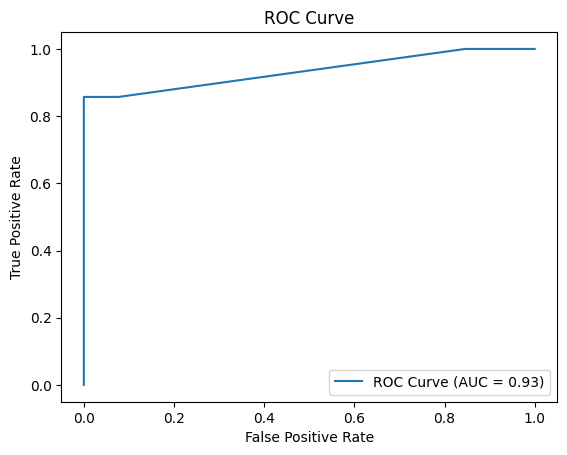

In [177]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

print("Classification Report:")
print(classification_report(y_val, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [178]:
# see coefficients
coefficients = pd.DataFrame({'feature': X_train.columns, 'coefficient': model.coef_[0]})
coefficients.sort_values(by='coefficient', ascending=False)

,feature,coefficient
3,num_radiochemo,0.642168
0,num_cancer,0.630789
2,num_metastasis,0.457075
1,num_tumor,0.299936
6,num_trauma,0.130546
5,num_antibiotic,-0.393489
4,num_minor,-0.580791


In [200]:
# show dataframe of cancer_labelval['has_cancer'], all prediction scores, probabilities
pred_logit = cancer_labelval[['patient_identifier', 'has_cancer']].copy()
pred_logit['prediction'] = y_pred
pred_logit['probability'] = y_pred_prob

pred_logit.sort_values(by='probability', ascending=False)

,patient_identifier,has_cancer,prediction,probability
8,1949,1.0,1.0,0.991418
29,418,1.0,1.0,0.984434
49,1207,1.0,1.0,0.836884
20,2762,1.0,1.0,0.787441
22,1047,1.0,1.0,0.765549
17,2260,1.0,1.0,0.565620
25,2706,0.0,0.0,0.470765
37,141,0.0,0.0,0.406570
10,1170,0.0,0.0,0.406570
14,1320,0.0,0.0,0.406570


In [195]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, min_samples_split=3, random_state=1234)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_val)
y_pred_prob_rf = rf_model.predict_proba(X_val)[:, 1]  # Probability scores for positive class

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93        13
         1.0       1.00      0.71      0.83         7

    accuracy                           0.90        20
   macro avg       0.93      0.86      0.88        20
weighted avg       0.91      0.90      0.90        20

ROC-AUC Score: 0.85


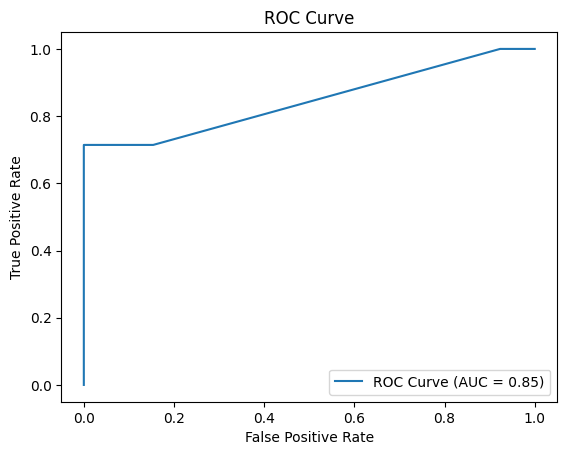

In [196]:

print("Classification Report:")
print(classification_report(y_val, y_pred_rf))

# ROC-AUC score
roc_auc = roc_auc_score(y_val, y_pred_prob_rf)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_rf)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [198]:
# show dataframe of cancer_labelval['has_cancer'], all prediction scores, probabilities
pred_rf = cancer_labelval[['patient_identifier', 'has_cancer']].copy()
pred_rf['prediction'] = y_pred_rf
pred_rf['probability'] = y_pred_prob_rf

pred_rf.sort_values(by='probability', ascending=False)

,patient_identifier,has_cancer,prediction,probability
8,1949,1.0,1.0,0.979529
29,418,1.0,1.0,0.966159
20,2762,1.0,1.0,0.864493
22,1047,1.0,1.0,0.822036
49,1207,1.0,1.0,0.635026
6,157,0.0,0.0,0.498205
25,2706,0.0,0.0,0.442538
37,141,0.0,0.0,0.249614
10,1170,0.0,0.0,0.249614
17,2260,1.0,0.0,0.249614


### Score unlabeled data

In [201]:
print(nolabeldat.shape)

# create dataframe of features from nolabeldat
nolabel_cancermoddat = cancer_logit_prep(nolabeldat).drop(columns=['patient_identifier'])

# predict on nolabel_cancermoddat
y_nolabel = logit_model.predict(nolabel_cancermoddat)
y_nolabel_prob = logit_model.predict_proba(nolabel_cancermoddat)[:, 1]

# merge predictions back to nolabeldat
cancer_nolabel = nolabeldat.copy()
cancer_nolabel['pred'] = y_nolabel
cancer_nolabel['pred_prob'] = y_nolabel_prob

cancer_nolabel.sort_values(by='pred_prob', ascending=False)

(1750, 5)


,patient_identifier,text,has_cancer,has_diabetes,test_set,pred,pred_prob
1418,2968,Discharge Summary:\n\nPatient Information:\nNa...,NaN,NaN,0,1.0,0.999997
562,311,"Discharge Summary:\n\nPatient: [Name], Female,...",NaN,NaN,0,1.0,0.999981
1207,1978,Hospital Course Summary:\n\nThis is a hospital...,NaN,NaN,0,1.0,0.999956
500,2650,DISCHARGE SUMMARY\n\nPatient Name: [redacted]\...,NaN,NaN,0,1.0,0.999943
1844,195,Discharge Summary:\nPatient Name: [Insert Name...,NaN,NaN,0,1.0,0.999926
...,...,...,...,...,...,...,...
177,3025,Hospital Course:\n\nThe patient presented to t...,NaN,NaN,0,0.0,0.087415
347,3054,"Hospital Course:\nThe patient, a 16 year-old K...",NaN,NaN,0,0.0,0.087415
75,2971,Discharge Summary:\n\nPatient Name: [REDACTED]...,NaN,NaN,0,0.0,0.060705
1857,3020,Discharge Summary:\n\nPatient: 62-year-old fem...,NaN,NaN,0,0.0,0.042546


pred
0.0    1110
1.0     640
Name: count, dtype: int64


(array([  3.,   5.,   9.,  23.,  47.,  54.,  76., 805.,  38.,  52.,  35.,
         76.,  48.,  40.,  59.,  33.,  70.,  58.,  65., 154.]),
 array([0.02057459, 0.06954569, 0.11851679, 0.1674879 , 0.216459  ,
        0.2654301 , 0.3144012 , 0.36337231, 0.41234341, 0.46131451,
        0.51028562, 0.55925672, 0.60822782, 0.65719892, 0.70617003,
        0.75514113, 0.80411223, 0.85308334, 0.90205444, 0.95102554,
        0.99999664]),
 <BarContainer object of 20 artists>)

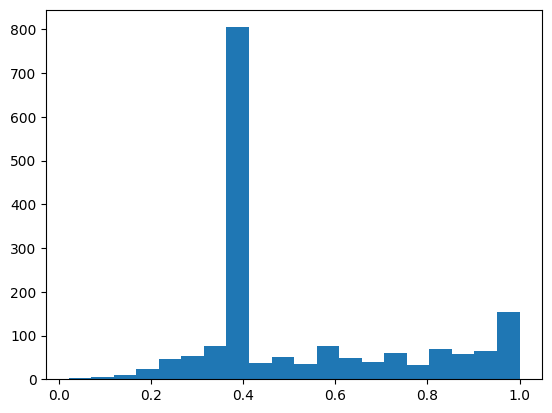

In [202]:
print(cancer_nolabel['pred'].value_counts())
# plot histogram of pred_prob
plt.hist(cancer_nolabel['pred_prob'], bins=20)

In [203]:
# check probabilities for top 10% and bottom 10% of pred_prob
print(cancer_nolabel['pred_prob'].quantile(0.1))
print(cancer_nolabel['pred_prob'].quantile(0.9))

# low probability is actually very small number, since we have a huge spike at ~0.42
print(cancer_nolabel.loc[cancer_nolabel['pred_prob'] < cancer_nolabel['pred_prob'].quantile(0.1), 'pred'].value_counts())
print(cancer_nolabel.loc[cancer_nolabel['pred_prob'] > cancer_nolabel['pred_prob'].quantile(0.9), 'pred'].value_counts())

# separate those out
cancer_lowprob = cancer_nolabel.loc[cancer_nolabel['pred_prob'] < cancer_nolabel['pred_prob'].quantile(0.1)]
cancer_highprob = cancer_nolabel.loc[cancer_nolabel['pred_prob'] > cancer_nolabel['pred_prob'].quantile(0.9)]
cancer_medprob = cancer_nolabel.loc[(cancer_nolabel['pred_prob'] >= cancer_nolabel['pred_prob'].quantile(0.1)) & (cancer_nolabel['pred_prob'] <= cancer_nolabel['pred_prob'].quantile(0.9))]

# write out to csv for some manual analysis
cancer_lowprob.to_csv('data/cancer_lowprob.csv', index=False)
cancer_highprob.to_csv('data/cancer_highprob.csv', index=False)

0.3161214813803545
0.9413528709470597
pred
0.0    142
Name: count, dtype: int64
pred
1.0    170
Name: count, dtype: int64


In [217]:
# take some samples from the middle probability group, especially those with lots of 0s in modeling dataframe
cancer_medprob.columns
df_medprob = cancer_logit_prep(cancer_medprob)
df_medprob.columns

Index(['patient_identifier', 'num_cancer', 'num_tumor', 'num_metastasis',
       'num_radiochemo', 'num_minor', 'num_antibiotic', 'num_trauma'],
      dtype='object')

In [227]:
print(df_medprob.shape)
# create sum column that sums across num_cancer, num_tumor, etc
df_medprob['sum'] = (df_medprob['num_cancer'] + 
                    df_medprob['num_tumor'] + 
                    df_medprob['num_metastasis'] + 
                    df_medprob['num_radiochemo'] + 
                    df_medprob['num_minor'] + 
                    df_medprob['num_antibiotic'] + 
                    df_medprob['num_trauma'])
# filter for sum==0, and sample 50 rows
samp_medprob = df_medprob.loc[df_medprob['sum'] == 0].sample(50)

samp_medprob = samp_medprob.merge(cancer_medprob, on="patient_identifier")
samp_medprob.drop(columns=['num_cancer', 'num_tumor', 'num_metastasis', 
                           'num_radiochemo', 'num_minor', 'num_antibiotic', 'num_trauma'], 
                           inplace=True)
print(samp_medprob.columns)

samp_medprob.to_csv('data/cancer_pseudo_medprob_sample.csv')

(1438, 9)
Index(['patient_identifier', 'sum', 'text', 'has_cancer', 'has_diabetes',
       'test_set', 'pred', 'pred_prob'],
      dtype='object')


In [235]:
manual_cancer_medprob = pd.read_csv('data/manual_cancer_pseudo_medprob_sample.csv')
[print(manual_cancer_medprob['has_cancer'].sum())]
manual_cancer_medprob.columns


7


Index(['patient_identifier', 'text', 'has_cancer', 'has_diabetes', 'test_set'], dtype='object')

## Add in top and bottom 10% as pseudo-labeled data

In [236]:
pseudo_train_cancer = cancer_highprob.copy().drop(columns=['pred', 'pred_prob'])
pseudo_train_cancer['has_cancer'] = 1

pseudo_train_nocancer = cancer_lowprob.copy().drop(columns=['pred', 'pred_prob'])
pseudo_train_nocancer['has_cancer'] = 0

cancer_pseudotrain = pd.concat([cancer_labeltrain, pseudo_train_cancer, pseudo_train_nocancer, manual_cancer_medprob])
print(cancer_pseudotrain.shape)

(392, 5)


In [241]:
cancer_pseudotrain.to_csv('data/cancer_pseudotrain.csv', index=False)

cancer_nolabeldat_pseudo = nolabeldat.loc[~nolabeldat['patient_identifier'].isin(cancer_pseudotrain['patient_identifier'])] 
cancer_nolabeldat_pseudo.to_csv('data/cancer_nolabels_pseudotrain.csv', index=False)

In [240]:
# filter nolabeldat for patient_identifier not in cancer_pseudotrain
nolabeldat_filtered = nolabeldat.loc[~nolabeldat['patient_identifier'].isin(cancer_pseudotrain['patient_identifier'])] 

(1750, 5)

## rerun logit model

In [237]:
# logistic regression 
X_train = cancer_logit_prep(cancer_pseudotrain).drop(columns=['patient_identifier'])
y_train = cancer_pseudotrain['has_cancer']
X_val = cancer_logit_prep(cancer_labelval).drop(columns=['patient_identifier'])
y_val = cancer_labelval['has_cancer']

pseudologit_model = LogisticRegression(solver='liblinear', class_weight='balanced', C=0.5)  # 'balanced' handles class imbalance
pseudologit_model.fit(X_train, y_train)

y_pred = pseudologit_model.predict(X_val)
y_pred_prob = pseudologit_model.predict_proba(X_val)[:, 1]  # Probability scores for positive class


Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93        13
         1.0       1.00      0.71      0.83         7

    accuracy                           0.90        20
   macro avg       0.93      0.86      0.88        20
weighted avg       0.91      0.90      0.90        20

ROC-AUC Score: 0.93


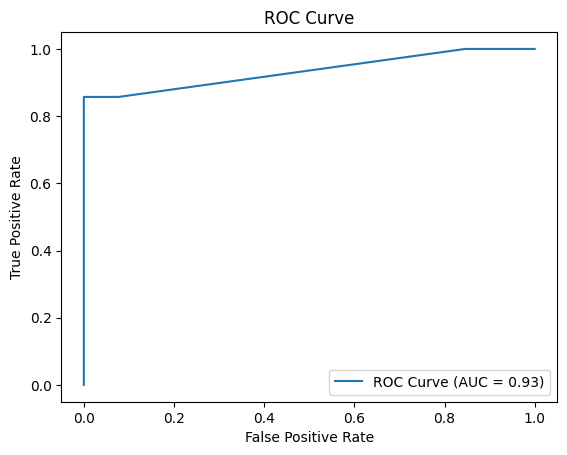

In [238]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

print("Classification Report:")
print(classification_report(y_val, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [239]:
# see new coefficients
coefficients_pseudo = pd.DataFrame({'feature': X_train.columns, 'coefficient': pseudologit_model.coef_[0]})
coefficients_pseudo.sort_values(by='coefficient', ascending=False)

,feature,coefficient
0,num_cancer,1.170728
3,num_radiochemo,1.091201
2,num_metastasis,0.740047
1,num_tumor,0.545592
6,num_trauma,0.188125
5,num_antibiotic,-1.105393
4,num_minor,-1.507732


In [214]:
# recall previous coefs
coefficients.sort_values(by='coefficient', ascending=False)

,feature,coefficient
3,num_radiochemo,0.642168
0,num_cancer,0.630789
2,num_metastasis,0.457075
1,num_tumor,0.299936
6,num_trauma,0.130546
5,num_antibiotic,-0.393489
4,num_minor,-0.580791


# OTHER